# Global probing FPR visualizations (heatmaps + layer trends)

Loads `fpr_by_layer_triplet.csv` from these runs:
- `output/probing_global/scene_description_balanced_2d_internvl2-26b`
- `output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct`
- `output/probing_global/scene_description_balanced_2d_qwen2.5-VL-32B-Instruct`
- `output/probing_global/scene_description_balanced_2d_qwen3_vl_30b`

And plots:
1) Heatmaps of implied vs non-implied FPR across **layers × triplet counts**.
2) Trend plots (FPR vs triplet count) for representative layers (see `REP_LAYERS_BY_MODEL`; default: **0, 10, 20, last**).


In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

ROOT = Path.cwd()

MODEL_RUN_DIRS = {
    "internvl2-26b": ROOT / "output" / "probing_global" / "scene_description_balanced_2d_internvl2-26b",
    "qwen2.5-VL-7B-Instruct": ROOT / "output" / "probing_global" / "scene_description_balanced_2d_qwen2.5-VL-7B-Instruct",
    "qwen2.5-VL-32B-Instruct": ROOT / "output" / "probing_global" / "scene_description_balanced_2d_qwen2.5-VL-32B-Instruct",
    "qwen3_vl_30b": ROOT / "output" / "probing_global" / "scene_description_balanced_2d_qwen3_vl_30b",
}

MODEL_RUN_DIRS

{'internvl2-26b': PosixPath('/gpfs/helios/home/kelemnegasi/binding-open-vlm/output/probing_global/scene_description_balanced_2d_internvl2-26b'),
 'qwen2.5-VL-7B-Instruct': PosixPath('/gpfs/helios/home/kelemnegasi/binding-open-vlm/output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct'),
 'qwen2.5-VL-32B-Instruct': PosixPath('/gpfs/helios/home/kelemnegasi/binding-open-vlm/output/probing_global/scene_description_balanced_2d_qwen2.5-VL-32B-Instruct'),
 'qwen3_vl_30b': PosixPath('/gpfs/helios/home/kelemnegasi/binding-open-vlm/output/probing_global/scene_description_balanced_2d_qwen3_vl_30b')}

In [2]:
def load_fpr_by_layer_triplet(run_dir: Path) -> pd.DataFrame:
    csv_path = run_dir / "probes" / "fpr_by_layer_triplet.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing: {csv_path}")
    df = pd.read_csv(csv_path)
    # Keep only the pooled patch representation
    df = df[df["representation"] == "patch_mean_pool"].copy()
    df["layer"] = pd.to_numeric(df["layer"], errors="raise").astype(int)
    df["scene_complexity_triplet_count"] = pd.to_numeric(
        df["scene_complexity_triplet_count"], errors="raise"
    ).astype(int)
    return df


def pivot_heatmap(
    df: pd.DataFrame,
    value_col: str,
    index_col: str = "scene_complexity_triplet_count",
    column_col: str = "layer",
) -> pd.DataFrame:
    # Use mean in case there are duplicates
    pivot = df.pivot_table(
        index=index_col,
        columns=column_col,
        values=value_col,
        aggfunc="mean",
    )
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)
    return pivot


def plot_heatmap(ax, mat: np.ndarray, xlabels: list[int], ylabels: list[int], title: str) -> None:
    im = ax.imshow(mat, aspect="auto", origin="lower", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Triplet count")

    # Ticks: reduce density for readability
    if len(xlabels) <= 25:
        xticks = np.arange(len(xlabels))
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(x) for x in xlabels], rotation=90)
    else:
        step = max(1, len(xlabels) // 12)
        xticks = np.arange(0, len(xlabels), step)
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(xlabels[i]) for i in xticks], rotation=90)

    if len(ylabels) <= 25:
        yticks = np.arange(len(ylabels))
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(y) for y in ylabels])
    else:
        step = max(1, len(ylabels) // 12)
        yticks = np.arange(0, len(ylabels), step)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(ylabels[i]) for i in yticks])

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="FPR")


dfs = {name: load_fpr_by_layer_triplet(run_dir) for name, run_dir in MODEL_RUN_DIRS.items()}
{k: v.shape for k, v in dfs.items()}

{'internvl2-26b': (1665, 8),
 'qwen2.5-VL-7B-Instruct': (1036, 8),
 'qwen2.5-VL-32B-Instruct': (2368, 8),
 'qwen3_vl_30b': (1776, 8)}

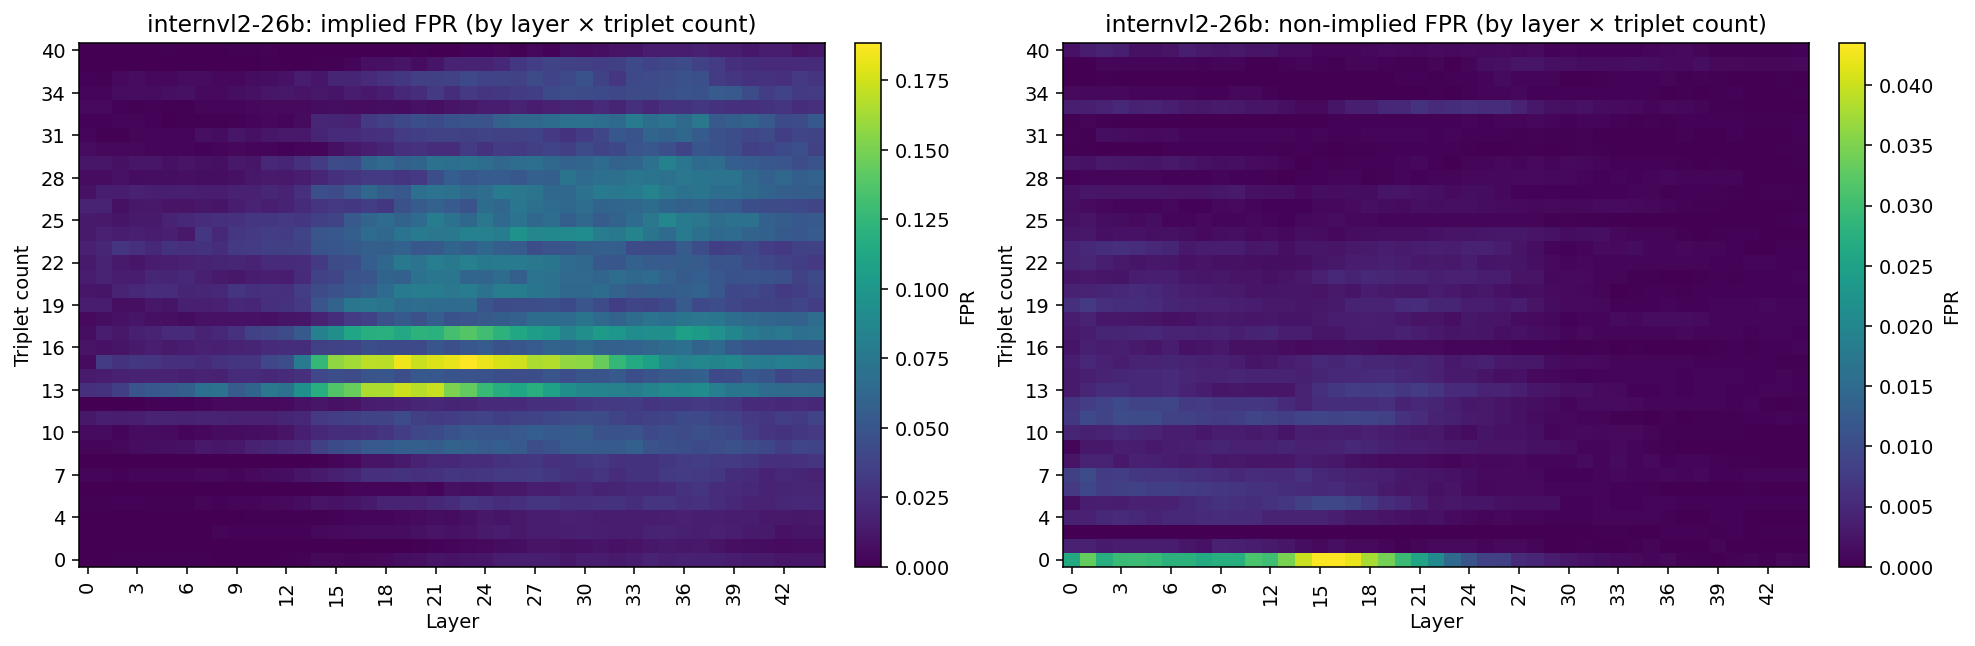

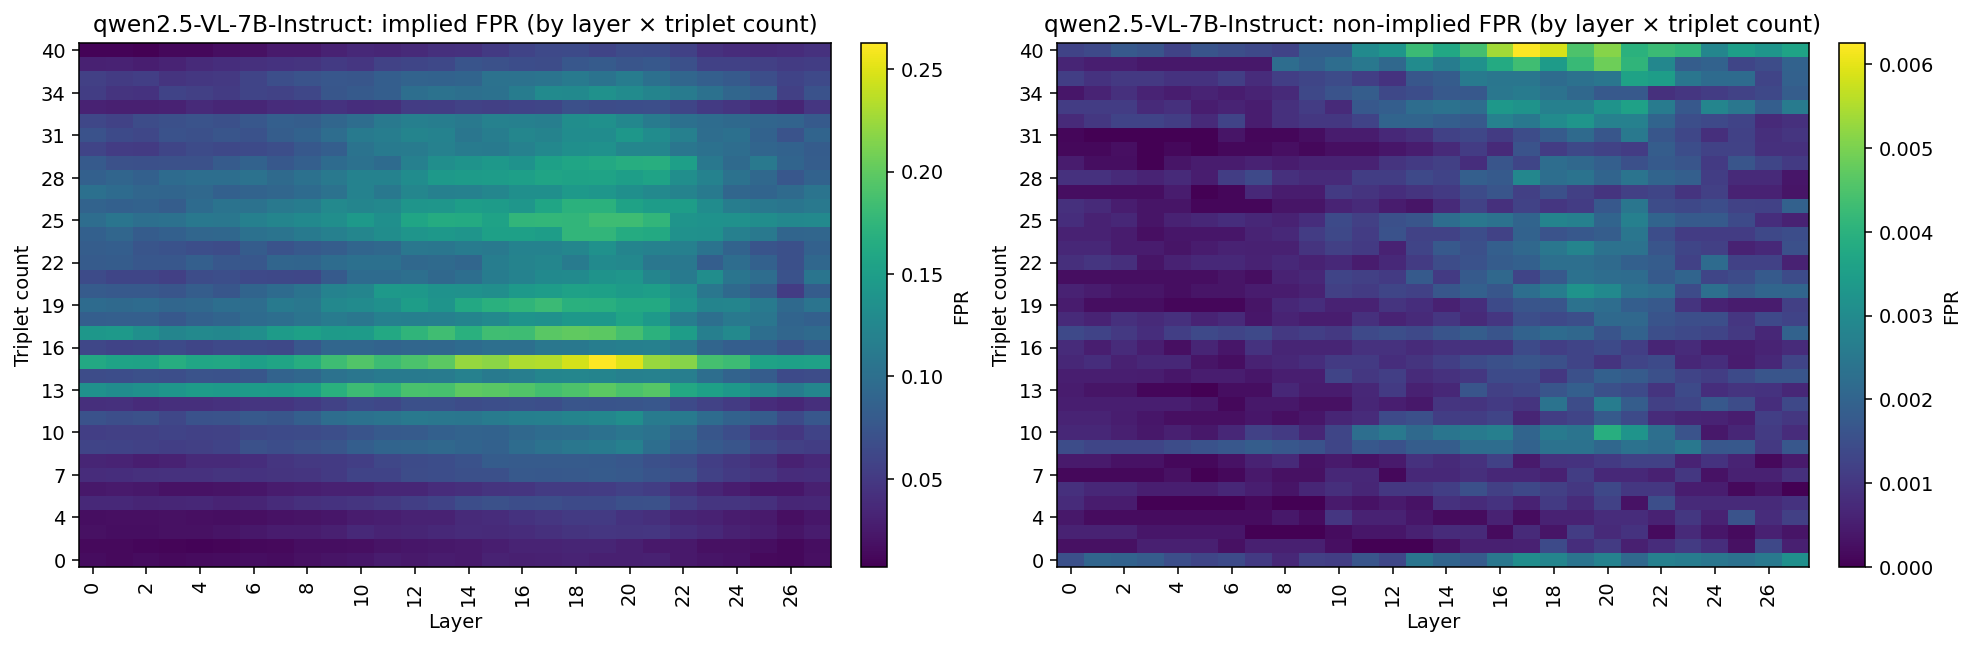

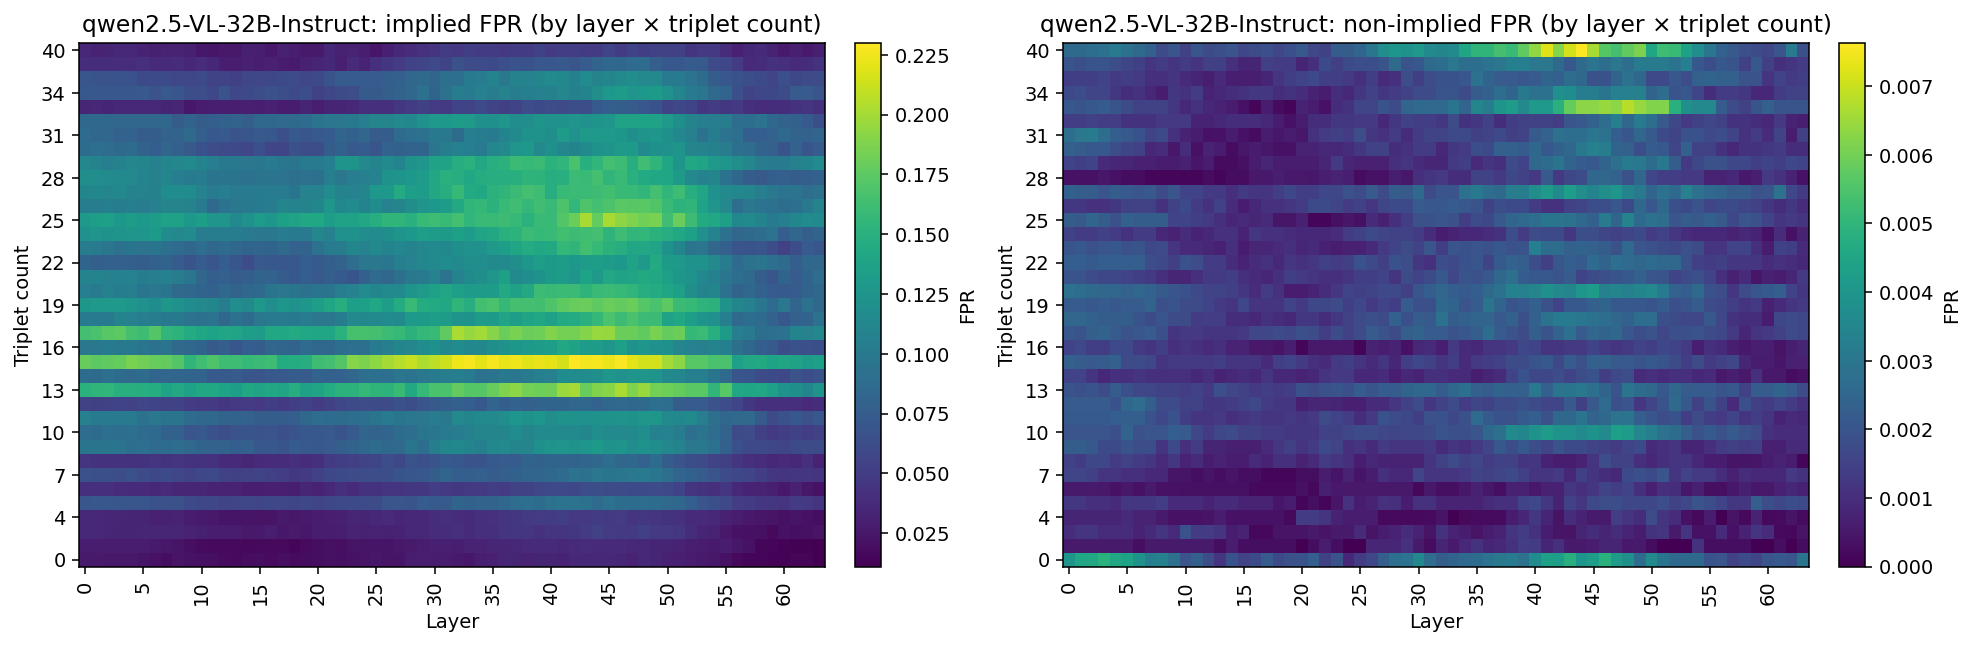

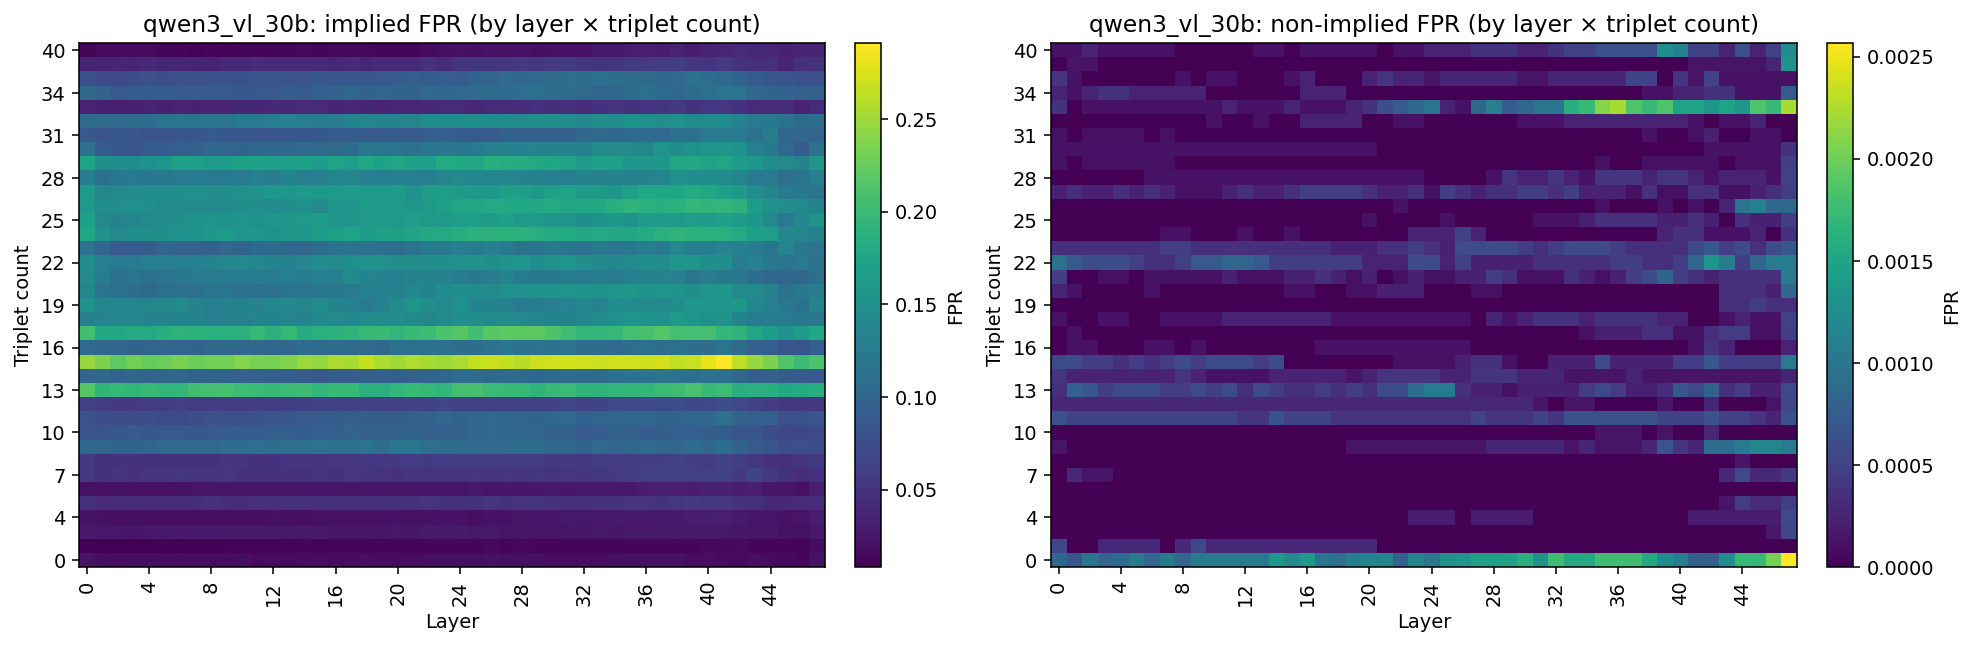

In [3]:
for model_name, df in dfs.items():
    implied = pivot_heatmap(df, "implied_fpr_mean")
    non_implied = pivot_heatmap(df, "non_implied_fpr_mean")

    # Align indices/columns just in case
    triplets = sorted(set(implied.index) | set(non_implied.index))
    layers = sorted(set(implied.columns) | set(non_implied.columns))
    implied = implied.reindex(index=triplets, columns=layers)
    non_implied = non_implied.reindex(index=triplets, columns=layers)

    fig, axs = plt.subplots(1, 2, figsize=(14, 4.5), constrained_layout=True)
    plot_heatmap(
        axs[0],
        implied.to_numpy(dtype=float),
        xlabels=list(implied.columns.astype(int)),
        ylabels=list(implied.index.astype(int)),
        title=f"{model_name}: implied FPR (by layer × triplet count)",
    )
    plot_heatmap(
        axs[1],
        non_implied.to_numpy(dtype=float),
        xlabels=list(non_implied.columns.astype(int)),
        ylabels=list(non_implied.index.astype(int)),
        title=f"{model_name}: non-implied FPR (by layer × triplet count)",
    )
    plt.show()

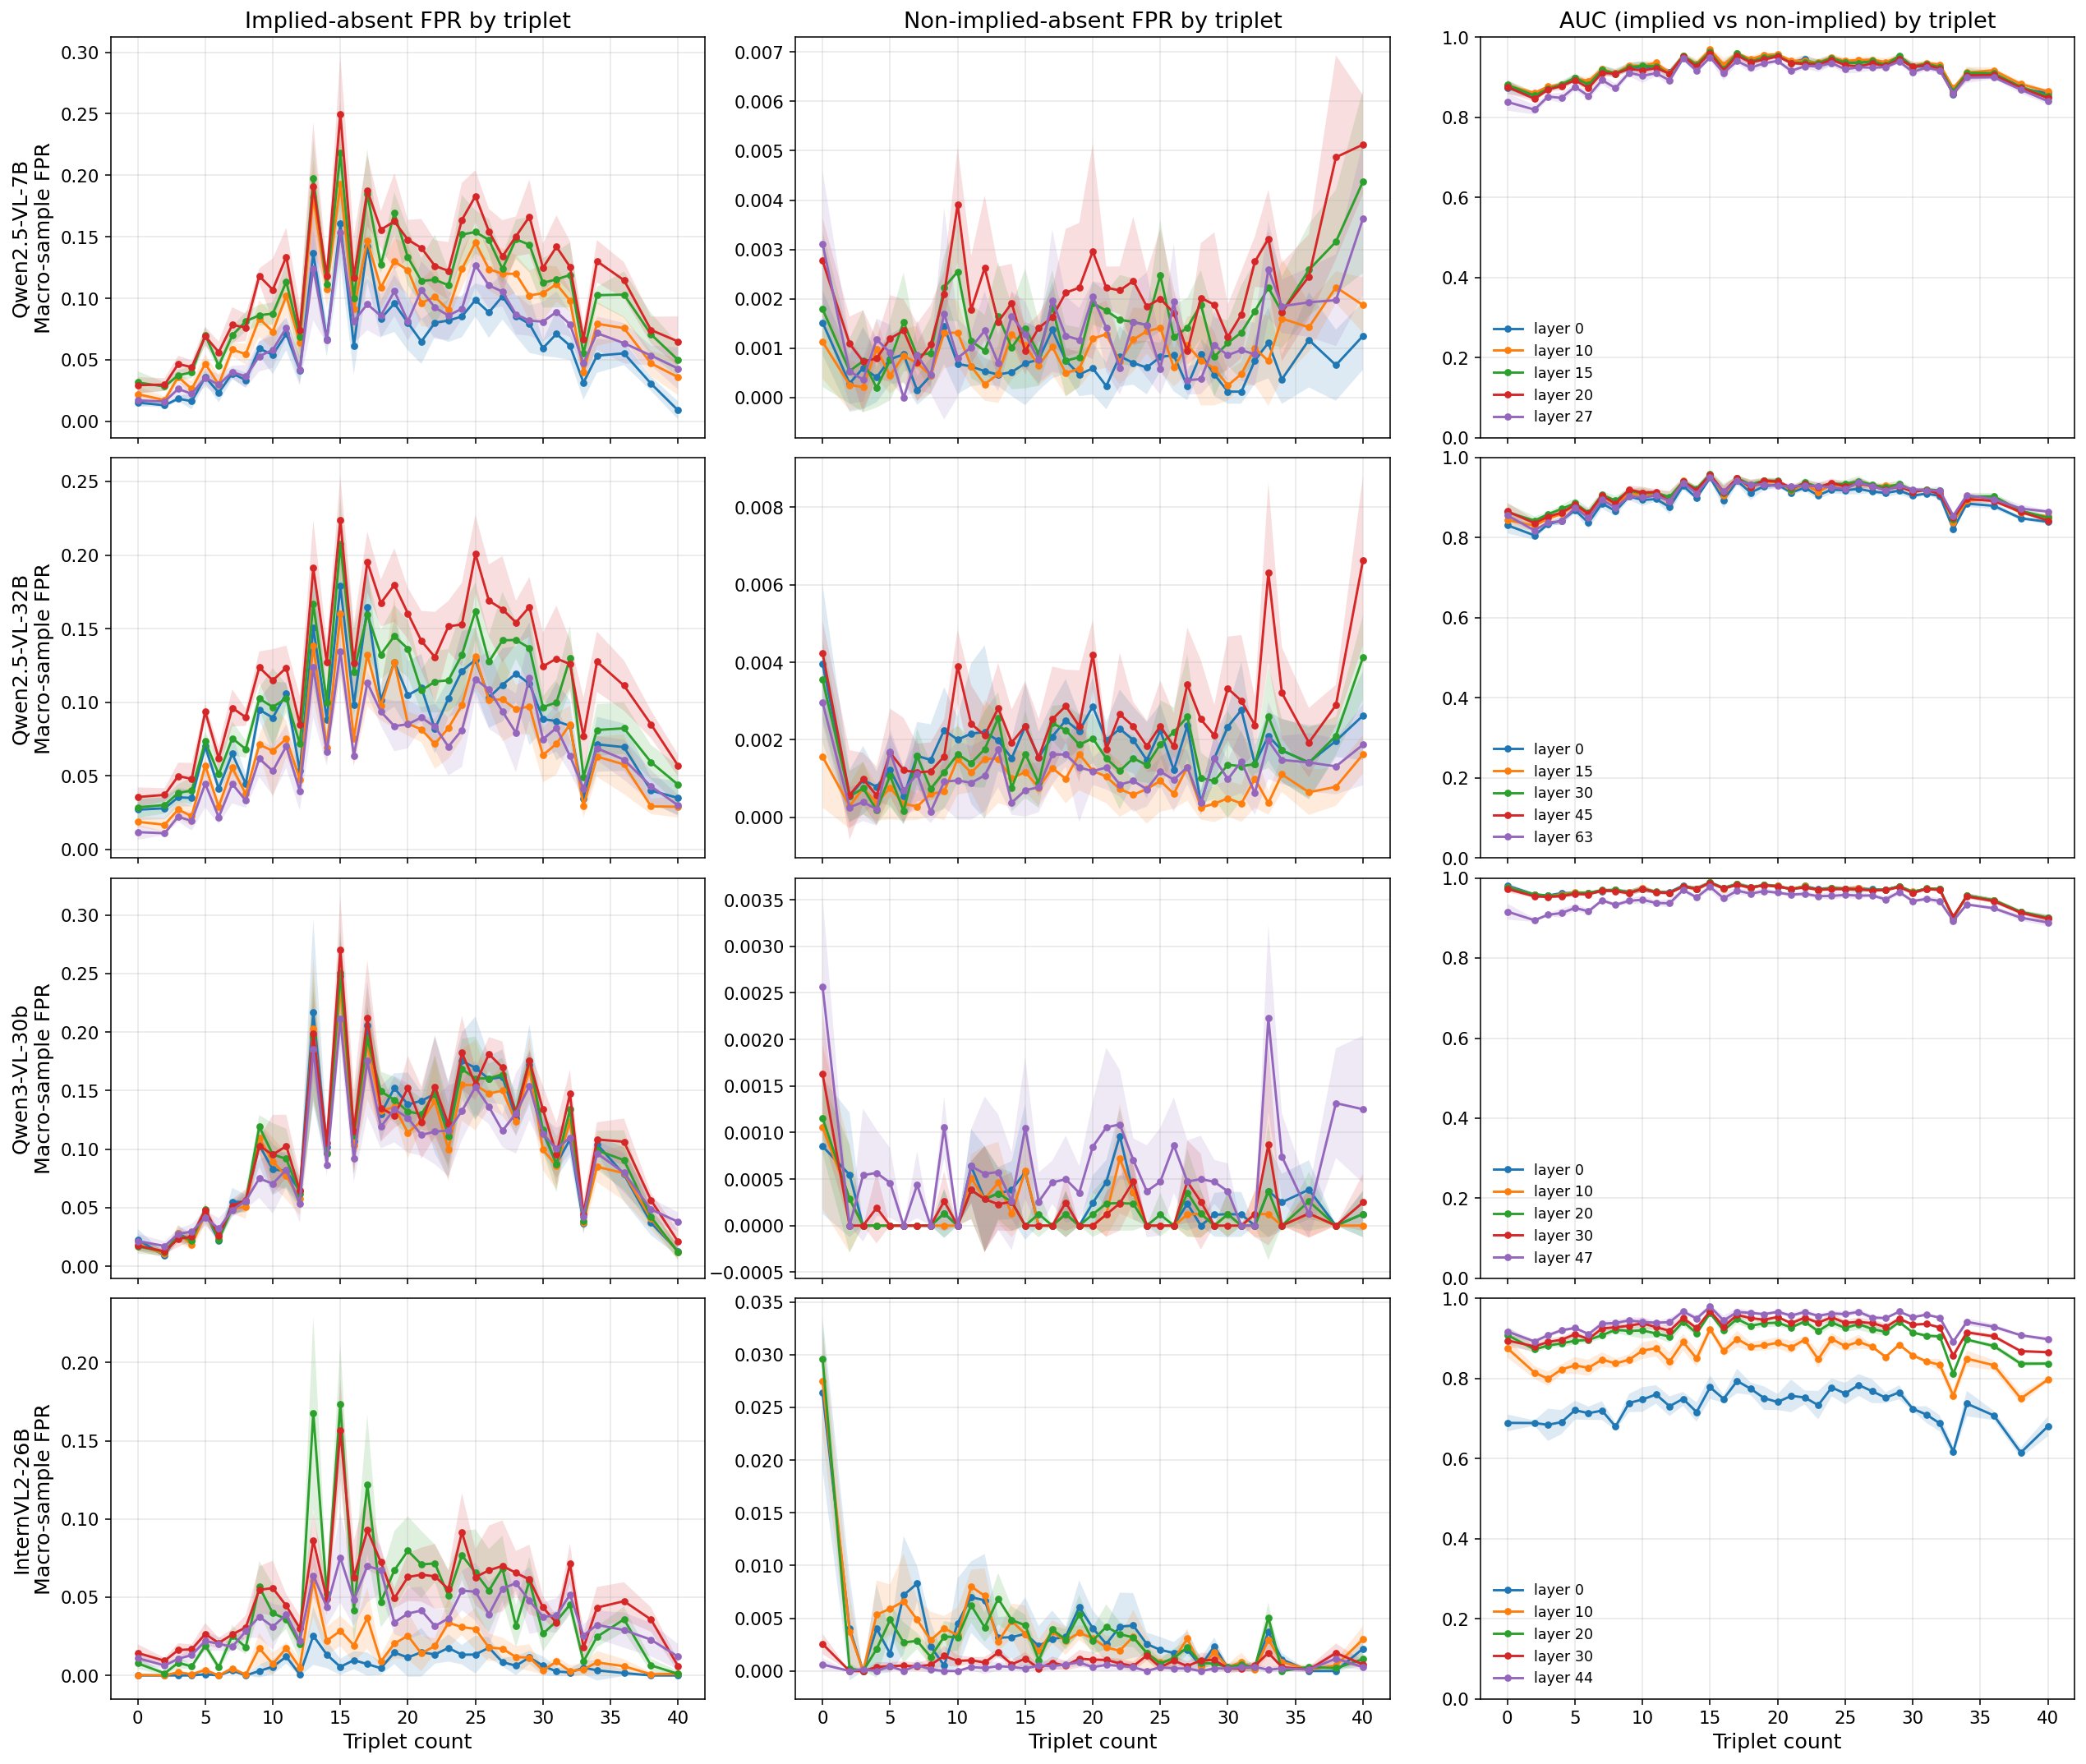

Saved:
- analysis/plots/triplet_metrics__qwen2-5-vl-7b__qwen2-5-vl-32b__qwen3-vl-30b__internvl2-26b__impl-non-auc.png
- analysis/plots/triplet_metrics__qwen2-5-vl-7b__qwen2-5-vl-32b__qwen3-vl-30b__internvl2-26b__impl-non-auc.pdf


In [4]:
# Multi-model grid (each model = new row), panels as columns
import re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

MODEL_ORDER = [
    "qwen2.5-VL-7B-Instruct",
    "qwen2.5-VL-32B-Instruct",
    "qwen3_vl_30b",
    "internvl2-26b",
]

SHOW_KEYS = ["impl", "non", "auc"]

# --- layout / sizing ---
FIG_W_PER_COL = 6.0
FIG_H_PER_ROW = 3.8
DPI = 200
SAVE_DIR = Path("analysis/plots")

# --- font sizes (tweak these to taste) ---
TITLE_FS = 14
AXIS_LABEL_FS = 13
ROW_LABEL_FS = 13
TICK_FS = 11
LEGEND_FS = 9

# Optional: set global defaults so you don't have to chase font sizes
plt.rcParams.update({
    "font.size": TICK_FS,
    "axes.titlesize": TITLE_FS,
    "axes.labelsize": AXIS_LABEL_FS,
    "xtick.labelsize": TICK_FS,
    "ytick.labelsize": TICK_FS,
    "legend.fontsize": LEGEND_FS,
})

# --- spacing: tighter rows/cols ---
WSPACE = 0.12  # closer columns
HSPACE = 0.08  # tighter rows

def short_model_label(model_name: str) -> str:
    s = str(model_name)
    s = s.replace("_", "-")
    s = re.sub(r"^qwen", "Qwen", s, flags=re.IGNORECASE)
    s = re.sub(r"^internvl", "InternVL", s, flags=re.IGNORECASE)
    s = re.sub(r"\bvl\b", "VL", s, flags=re.IGNORECASE)
    s = re.sub(r"-26b\b", "-26B", s, flags=re.IGNORECASE)
    s = s.replace("-Instruct", "")
    return s

def slugify(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^\w\-]+", "-", s)
    s = re.sub(r"-{2,}", "-", s)
    return s.strip("-")

PANELS = {
    "impl": ("Implied-absent FPR by triplet", "Macro-sample FPR"),
    "non": ("Non-implied-absent FPR by triplet", "Macro-sample FPR"),
    "auc": ("AUC (implied vs non-implied) by triplet", "AUC"),
}

REP_LAYERS_BY_MODEL = {
    "qwen3_vl_30b": [0, 10, 20, 30, "last"],
    "qwen2.5-VL-32B-Instruct": [0, 15, 30, 45, "last"],
    "qwen2.5-VL-7B-Instruct": [0, 10, 15, 20, "last"],
    "internvl2-26b": [0, 10, 20, 30, "last"],
}

def representative_layers(model_name: str, all_layers: list[int]) -> list[int]:
    if not all_layers:
        return []
    last = max(all_layers)
    wanted = REP_LAYERS_BY_MODEL.get(model_name, [0, 10, 20, "last"])
    wanted = [last if w == "last" else int(w) for w in wanted]
    return [l for l in wanted if l in set(all_layers)]

def per_sample_auc_by_triplet(npz_path: Path) -> dict[int, float]:
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_score = z["y_score"].astype(float)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    auc_s = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        mi, mn = implied[i], non_implied[i]
        if not mi.any() or not mn.any():
            continue
        s_implied = y_score[i, mi]
        s_non = y_score[i, mn]
        y = np.concatenate([
            np.ones(len(s_implied), dtype=int),
            np.zeros(len(s_non), dtype=int),
        ])
        s = np.concatenate([s_implied, s_non])
        try:
            auc_s[i] = roc_auc_score(y, s)
        except ValueError:
            pass

    out: dict[int, float] = {}
    for t in np.unique(triplet):
        vals = auc_s[triplet == t]
        vals = vals[np.isfinite(vals)]
        out[int(t)] = float(vals.mean()) if len(vals) else float("nan")
    return out

def agg(dicts: list[dict[int, float]]) -> tuple[list[int], np.ndarray, np.ndarray]:
    all_t = sorted({t for d in dicts for t in d.keys()})
    mat = np.array([[d.get(t, np.nan) for t in all_t] for d in dicts], dtype=float)
    return all_t, np.nanmean(mat, axis=0), np.nanstd(mat, axis=0)

def auc_mean_std_by_triplet(inter_dir: Path, layer: int, triplets: list[int]) -> tuple[np.ndarray, np.ndarray]:
    files = sorted(inter_dir.glob(f"X_{int(layer)}_seed*.npz"))
    if not files:
        return (
            np.full(len(triplets), np.nan, dtype=float),
            np.full(len(triplets), np.nan, dtype=float),
        )

    per_seed = [per_sample_auc_by_triplet(p) for p in files]
    xs, mean, std = agg(per_seed)
    x_to_idx = {int(t): i for i, t in enumerate(xs)}
    mean_aligned = np.array([mean[x_to_idx[t]] if t in x_to_idx else np.nan for t in triplets], dtype=float)
    std_aligned = np.array([std[x_to_idx[t]] if t in x_to_idx else np.nan for t in triplets], dtype=float)
    return mean_aligned, std_aligned

# ---- main plotting ----
models = [(m, dfs[m]) for m in MODEL_ORDER if m in dfs]
if not models:
    raise ValueError(f"None of MODEL_ORDER found in dfs. Available: {list(dfs.keys())}")

n_rows = len(models)
n_cols = len(SHOW_KEYS)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(FIG_W_PER_COL * n_cols, FIG_H_PER_ROW * n_rows),
    sharex=True,
    sharey=False,
    squeeze=False,
)

# tighter packing of grid
fig.subplots_adjust(
    left=0.16,
    right=0.99,
    top=0.95,
    bottom=0.10,
    wspace=WSPACE,
    hspace=HSPACE,
)

for r, (model_name, df) in enumerate(models):
    impl_mean = pivot_heatmap(df, "implied_fpr_mean")
    impl_std = pivot_heatmap(df, "implied_fpr_std")
    non_mean = pivot_heatmap(df, "non_implied_fpr_mean")
    non_std = pivot_heatmap(df, "non_implied_fpr_std")

    triplets = impl_mean.index.astype(int).tolist()
    all_layers = impl_mean.columns.astype(int).tolist()
    layers = representative_layers(model_name, all_layers)

    inter_dir = MODEL_RUN_DIRS.get(model_name, None)
    inter_dir = (inter_dir / "probes" / "intermediates") if inter_dir is not None else None

    for c, key in enumerate(SHOW_KEYS):
        ax = axes[r, c]
        title, ylabel = PANELS[key]

        if key == "impl":
            mean_tbl, std_tbl = impl_mean, impl_std
            for layer in layers:
                y = mean_tbl[layer].to_numpy(dtype=float)
                s = std_tbl[layer].to_numpy(dtype=float)
                ax.plot(triplets, y, marker="o", linewidth=1.5, markersize=3.5, label=f"layer {layer}")
                ax.fill_between(triplets, y - s, y + s, alpha=0.15)

        elif key == "non":
            mean_tbl, std_tbl = non_mean, non_std
            for layer in layers:
                y = mean_tbl[layer].to_numpy(dtype=float)
                s = std_tbl[layer].to_numpy(dtype=float)
                ax.plot(triplets, y, marker="o", linewidth=1.5, markersize=3.5, label=f"layer {layer}")
                ax.fill_between(triplets, y - s, y + s, alpha=0.15)

        else:  # auc
            if inter_dir is None or not inter_dir.exists():
                ax.text(0.5, 0.5, f"No intermediates in\n{inter_dir}", ha="center", va="center", fontsize=TICK_FS)
                ax.set_axis_off()
                continue
            for layer in layers:
                y, s = auc_mean_std_by_triplet(inter_dir, layer, triplets)
                ax.plot(triplets, y, marker="o", linewidth=1.5, markersize=3.5, label=f"layer {layer}")
                ax.fill_between(triplets, y - s, y + s, alpha=0.15)
            ax.set_ylim(0.0, 1.0)

        # ---- titles (top row only) ----
        if r == 0:
            ax.set_title(title, fontsize=TITLE_FS, pad=6)

        # ---- x label only on last row; hide x tick labels elsewhere ----
        if r == n_rows - 1:
            ax.set_xlabel("Triplet count", fontsize=AXIS_LABEL_FS)
            ax.tick_params(axis="x", labelbottom=True, labelsize=TICK_FS)
        else:
            ax.set_xlabel("")
            ax.tick_params(axis="x", labelbottom=False)

        # ---- y label only on first column ----
        if c == 0:
            ax.set_ylabel(f"{short_model_label(model_name)}\n{ylabel}", fontsize=ROW_LABEL_FS)
        else:
            ax.set_ylabel("")

        # ticks / grid
        ax.tick_params(axis="y", labelsize=TICK_FS)
        ax.grid(alpha=0.3)

        # legend on last column
        if c == n_cols - 1:
            ax.legend(fontsize=LEGEND_FS, frameon=False, loc="best")

# Optional final tighten (small pads so it doesn't spread things)
fig.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)

SAVE_DIR.mkdir(parents=True, exist_ok=True)
models_slug = "__".join(slugify(short_model_label(m)) for m, _ in models)
panels_slug = "-".join(SHOW_KEYS)
base = f"triplet_metrics__{models_slug}__{panels_slug}"
png_path = SAVE_DIR / f"{base}.png"
pdf_path = SAVE_DIR / f"{base}.pdf"
fig.savefig(png_path, dpi=DPI, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
plt.show()
print(f"Saved:\n- {png_path}\n- {pdf_path}")

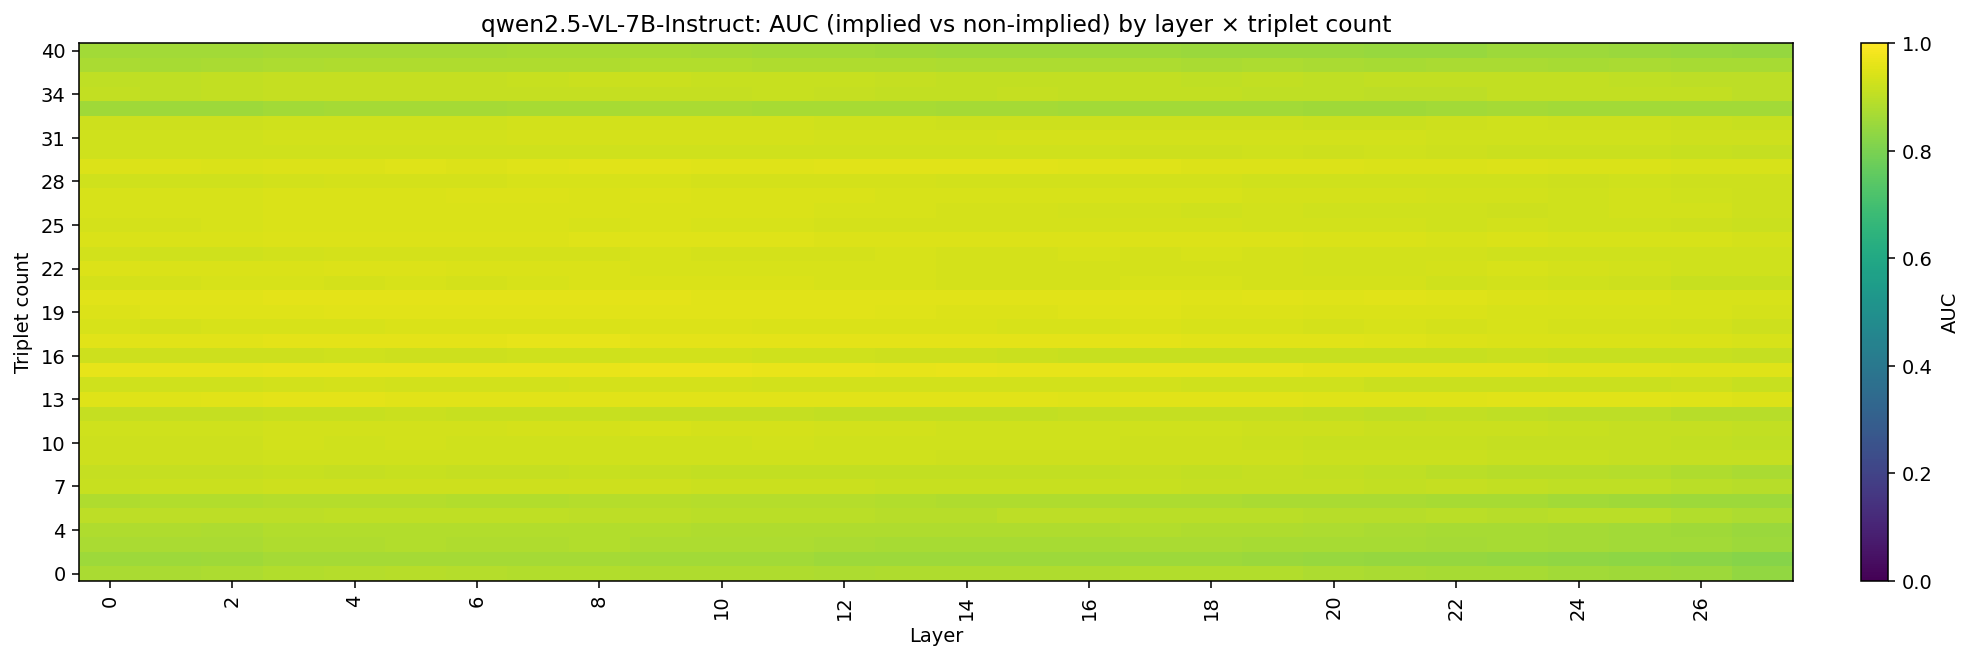

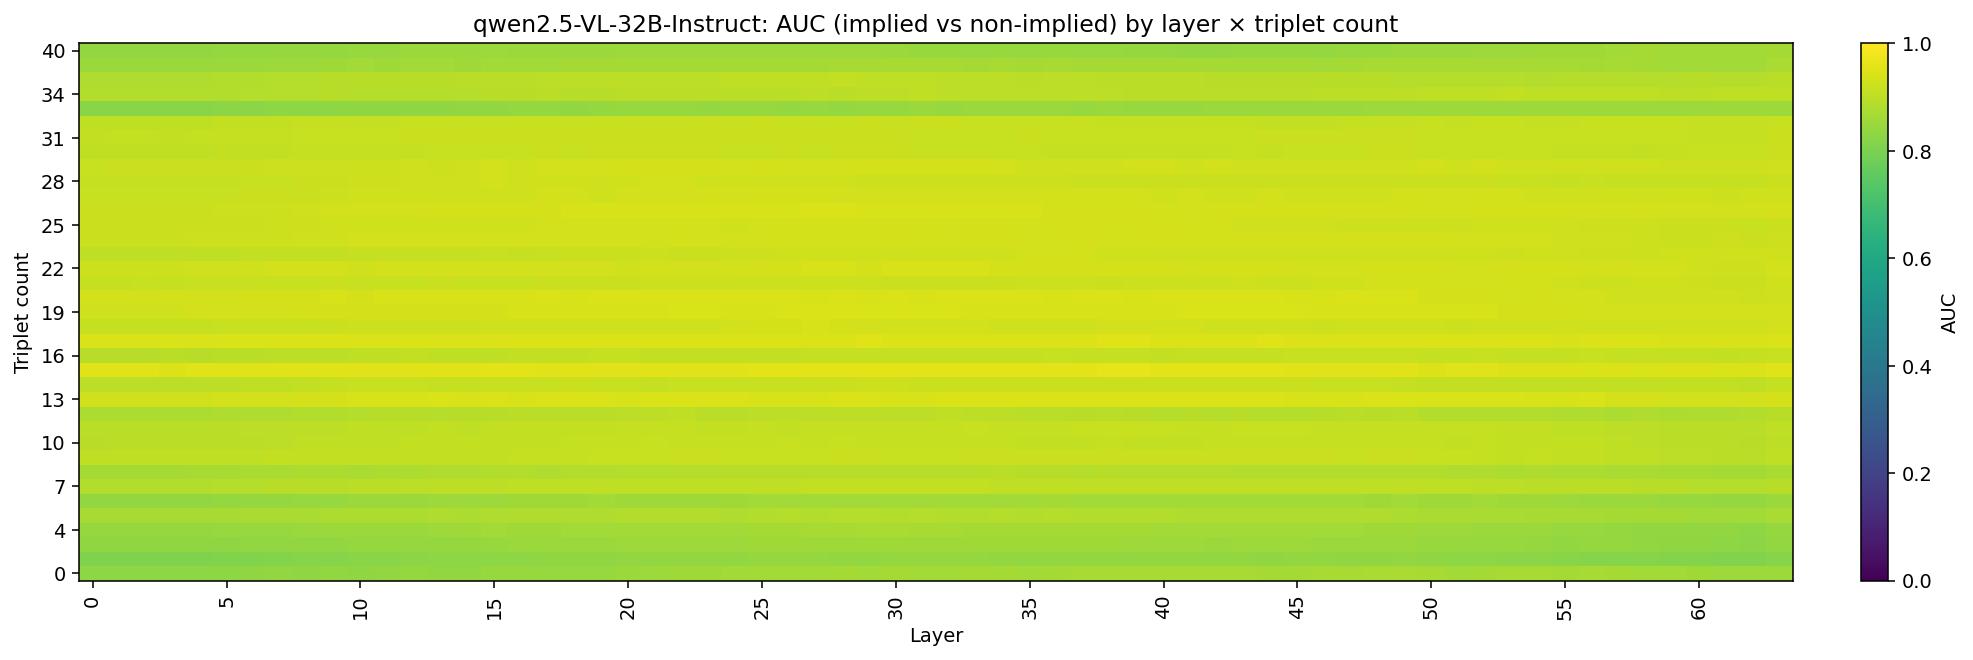

In [ ]:
# AUC heatmaps: implied vs non-implied (per layer × triplet count)
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


def per_sample_auc_by_triplet(npz_path: Path) -> dict[int, float]:
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_score = z["y_score"].astype(float)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    auc_s = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        mi, mn = implied[i], non_implied[i]
        if not mi.any() or not mn.any():
            continue
        s_implied = y_score[i, mi]
        s_non = y_score[i, mn]
        y = np.concatenate([
            np.ones(len(s_implied), dtype=int),
            np.zeros(len(s_non), dtype=int),
        ])
        s = np.concatenate([s_implied, s_non])
        try:
            auc_s[i] = roc_auc_score(y, s)
        except ValueError:
            pass

    out: dict[int, float] = {}
    for t in np.unique(triplet):
        vals = auc_s[triplet == t]
        vals = vals[np.isfinite(vals)]
        out[int(t)] = float(vals.mean()) if len(vals) else float("nan")
    return out


def agg(dicts: list[dict[int, float]]) -> tuple[list[int], np.ndarray, np.ndarray]:
    all_t = sorted({t for d in dicts for t in d.keys()})
    mat = np.array([[d.get(t, np.nan) for t in all_t] for d in dicts], dtype=float)
    return all_t, np.nanmean(mat, axis=0), np.nanstd(mat, axis=0)


def collect_auc_by_layer(model_run_dir: Path) -> dict[int, list[dict[int, float]]]:
    inter_dir = model_run_dir / "probes" / "intermediates"
    files = sorted(inter_dir.glob("X_*_seed*.npz"))
    if not files:
        raise FileNotFoundError(f"No intermediates found in {inter_dir}")

    by_layer: dict[int, list[dict[int, float]]] = {}
    for f in files:
        m = re.match(r"X_(\d+)_seed(\d+)\.npz$", f.name)
        if not m:
            continue
        layer = int(m.group(1))
        by_layer.setdefault(layer, []).append(per_sample_auc_by_triplet(f))
    return by_layer


def plot_auc_heatmap(model_name: str, run_dir: Path) -> None:
    by_layer = collect_auc_by_layer(run_dir)
    layers = sorted(by_layer.keys())
    triplets = sorted({t for ds in by_layer.values() for d in ds for t in d.keys()})

    # Build mean AUC matrix [triplet, layer]
    mat = np.full((len(triplets), len(layers)), np.nan, dtype=float)
    for j, layer in enumerate(layers):
        xs, mean, _std = agg(by_layer[layer])
        x_to_i = {int(t): i for i, t in enumerate(triplets)}
        for t, v in zip(xs, mean):
            mat[x_to_i[int(t)], j] = float(v)

    fig, ax = plt.subplots(1, 1, figsize=(14, 4.6), constrained_layout=True)
    im = ax.imshow(mat, aspect="auto", origin="lower", interpolation="nearest", vmin=0.0, vmax=1.0)
    ax.set_title(f"{model_name}: AUC (implied vs non-implied) by layer × triplet count")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Triplet count")

    # Tick density control
    if len(layers) <= 25:
        xticks = np.arange(len(layers))
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(x) for x in layers], rotation=90)
    else:
        step = max(1, len(layers) // 12)
        xticks = np.arange(0, len(layers), step)
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(layers[i]) for i in xticks], rotation=90)

    if len(triplets) <= 25:
        yticks = np.arange(len(triplets))
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(y) for y in triplets])
    else:
        step = max(1, len(triplets) // 12)
        yticks = np.arange(0, len(triplets), step)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(triplets[i]) for i in yticks])

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="AUC")
    plt.show()


for model_name, run_dir in MODEL_RUN_DIRS.items():
    try:
        plot_auc_heatmap(model_name, run_dir)
    except FileNotFoundError as e:
        print(f"[{model_name}] {e}")
